In [ ]:
!pip install shap
!pip install -U scikit-learn

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt; plt.rcParams.update({"figure.max_open_warning": 0, "figure.dpi": 100})
import shap

import joblib

In [ ]:
et_tuned_pipe = joblib.load("et_tuned_pipe.pkl") # The main notebook has to be run to create this file. It is not included in the zip due to its file size.

In [ ]:
preprocessor_pipe = et_tuned_pipe.named_steps['preprocess']

#### SHAP Interpretability for Our Final Tree Model

**a) Objective and motivation**

After our end-to-end pipeline is finished, we use **SHAP (SHapley Additive exPlanations)**.

Goals:
- Identify the **most influential features** for the final tuned model (`et_tuned_pipe`).
- Validate whether feature effects are **plausible** (age, mileage, engine, etc.).
- Check how much **target encodings** and engineered interactions contribute.

---

**b) Difficulty of the task**

This is non-trivial because SHAP must explain the model input **after** our preprocessing and feature selection:

- The model does not see raw columns.  
  It sees: engineered numeric features (e.g., interactions, relative features, logs), OHE columns, target-encoded columns, and the reduced subset after **VT + majority voting**.
- We therefore reconstruct:
  - the exact **post-preprocess feature matrix**, and
  - aligned **feature names** after applying both selection masks (VT support + majority selector mask).
- Because the full pipeline includes engineered preprocessing + selection, we treat the tuned pipeline as a **black box** and use SHAP via a **PermutationExplainer** (robust but expensive).
- Runtime: SHAP is costly, so we explain only a **subsample** (`sample_size=1000`) with a small background set.

---

**c) Correctness and efficiency**

We kept the analysis correct and consistent with the production pipeline:

- **No leakage / no optimization loop:** SHAP is computed on the already-fitted `et_tuned_pipe` and used only for interpretation.
- **Exact alignment:** feature names come from the ColumnTransformer output and are then filtered by VT + majority voting masks.
- **Global SHAP importance:** features are ranked by mean absolute contribution:

  $$
  Importance(feature_j) = \frac{1}{N}\sum_{i=1}^{N} |SHAP_{i,j}|
  $$

- **Efficient computation:** stable ranking via subsampling (PermutationExplainer on 1000 rows; runtime ≈ 21 minutes).

---

**d) Results and interpretation**

**Model context**
- Final tuned model: `et_tuned_pipe` (**ExtraTrees**)
- Total features used after preprocessing + FS: **30**
- SHAP explainer used: **PermutationExplainer**  
  (1001 iterations; runtime ≈ 21 minutes)

**Top drivers (mean |SHAP|), excerpt**

| Feature | Importance | Interpretation |
|---|---:|---|
| `median_te__model` | 1425.87 | Model-level median target encoding (strong price anchor) |
| `mean_te__model` | 1312.21 | Model-level mean target encoding (market value proxy) |
| `num__mpg_x_age` | 861.84 | Interaction capturing efficiency–age trade-offs |
| `num__age` | 741.45 | Direct age / depreciation signal |
| `num__engineSize` | 617.75 | Engine size as segment & performance proxy |
| `num__age_rel_brand` | 615.97 | Age relative to typical age within brand |
| `log__mileage` | 595.59 | Non-linear mileage effect (diminishing impact) |
| `cat__transmission_Manual` | 578.61 | Manual transmission effect |
| `mean_te__brand_trans` | 496.39 | Brand × transmission mean target encoding |
| `num__age_rel_model` | 445.87 | Age relative to typical age of the model |
| `median_te__brand_trans` | 434.62 | Brand × transmission median target encoding |
| `num__engine_per_mpg` | 321.67 | Performance vs. efficiency ratio |
| `log__miles_per_year` | 216.26 | Usage intensity normalized by age |

**Key takeaways**

- **Target encodings dominate global importance**, especially at the *model* level (`median_te__model`, `mean_te__model`).
- **Transmission is highly influential**, with `cat__transmission_Manual` ranking in the top 10.
- **Age and mileage effects are main drivers**, appearing in raw, relative, and non-linear forms.
- **Engine matters**, being in the top features right after TE models and age related features

### **Beeswarm plot observations**

- **`median_te__model` and `mean_te__model` show the widest SHAP dispersion**, confirming model identity as the strongest pricing signal.
- **Manual transmission has a clear directional effect**:  
  `cat__transmission_Manual = 1` tends to push predictions **down**, while non-manual pushes them **up**.
- **Mileage is strongly non-linear** (`log__mileage`), with diminishing marginal impact at high values.
- **Relative age features sharpen depreciation effects**, especially when vehicles are older than typical for their brand or model.

---

## **e) Alignment with objectives**

This SHAP analysis improves transparency of the models decision making:

- SHAP is used **only for post-hoc interpretation** of the final tuned pipeline.
- The dominant drivers—**target encodings, age, mileage, transmission, and engineered interactions**—are domain-consistent and support trust in the final ExtraTrees model.

##### Functions

In [ ]:
rs = 5
# Get Feature names aligned with X_proc (after preprocess incl. VT + majority voting)
def get_pipeline_feature_matrix(pipe, X, preprocessor_pipe):
    """
    Given a fitted model pipeline with steps:
      'preprocess' -> 'model'
    where preprocess itself is a Pipeline:
      clean -> group_imputer -> fe -> ct -> fs(vt + selector)
    return:
      X_proc: 2D numpy array of features just before the model step
      feat_names: 1D np.array of feature names aligned with X_proc columns
    """
    pre = pipe.named_steps["preprocess"]

    # Transform to model-ready matrix and get feature names
    X_proc = pre.transform(X)
    feat_names = preprocessor_pipe.named_steps['fs'].get_feature_names_out()

    return X_proc, feat_names


In [ ]:
# Compute SHAP Importance
def compute_shap_importance(
    pipe,
    X,
    sample_size=1000,
    seed=rs,
    model_name=None,
):
    """
    Compute global SHAP feature importances for a fitted pipeline (informative only).

    Fix:
      - TreeExplainer additivity check can fail for some sklearn tree implementations (incl. HGB).
        We disable it via check_additivity=False.
      - If TreeExplainer still fails, fall back to a model-agnostic SHAP explainer.
    """
    # Extract processed feature matrix and names
    X_proc, feat_names = get_pipeline_feature_matrix(pipe, X, preprocessor_pipe)

    # Convert to numpy if DataFrame (for proper integer indexing)
    if isinstance(X_proc, pd.DataFrame):
        X_proc = X_proc.values
    
    # Subsample rows for SHAP (for speed)
    rng = np.random.default_rng(seed)
    n = min(sample_size, len(X_proc))
    idx = rng.choice(len(X_proc), n, replace=False)
    X_sample = X_proc[idx]

    # Underlying model (last step in pipeline)
    model = pipe.named_steps["model"]
    tag = model_name or model.__class__.__name__

    # Background for SHAP (small subset)
    bg_n = min(200, len(X_sample))
    bg_idx = rng.choice(len(X_sample), bg_n, replace=False)
    X_bg = X_sample[bg_idx]

    # Try TreeExplainer first (fast for tree models)
    try:
        explainer = shap.TreeExplainer(model, X_bg)
        shap_vals = explainer.shap_values(X_sample, check_additivity=False)

        # shap_vals can be list-like in some setups; regression should be 2D
        if isinstance(shap_vals, list):
            shap_vals = shap_vals[0]

        base_vals = getattr(explainer, "expected_value", 0.0)
        shap_values = shap.Explanation(
            values=shap_vals,
            base_values=np.full((len(X_sample),), base_vals) if np.isscalar(base_vals) else base_vals,
            data=X_sample,
            feature_names=feat_names,
        )

    except Exception as e:
        # Fallback: model-agnostic explainer (slower but robust)
        explainer = shap.Explainer(model.predict, X_bg, feature_names=feat_names)
        shap_values = explainer(X_sample)

    importance = np.abs(shap_values.values).mean(axis=0)

    shap_df = (
        pd.DataFrame({"feature": feat_names, "importance": importance})
        .sort_values("importance", ascending=False)
        .reset_index(drop=True)
    )

    print(f"Features by SHAP for {tag}:")
    print(shap_df.head(40).to_string(index=False))

    return shap_df, feat_names, shap_values, X_sample


In [ ]:
# SHAP Plots
def plot_top_shap_bar(shap_df, model_name, top_k):
    """
    Horizontal bar plot of top_k features by mean |SHAP|.
    """
    top_df = shap_df.head(top_k).iloc[::-1]  # reverse for nicer barh order
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.barh(top_df["feature"], top_df["importance"])
    ax.set_xlabel("Average |SHAP| value")
    ax.set_title(f"Top {top_k} features by SHAP – {model_name}")
    plt.tight_layout()
    plt.show()


def plot_shap_beeswarm(shap_values, X_sample, feat_names, model_name, max_display=20):
    """
    SHAP summary (beeswarm) plot for top features.
    """
    X_df = pd.DataFrame(X_sample, columns=feat_names)

    # Create one figure and tell SHAP not to auto-show
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values.values, X_df, max_display=max_display, show=False)

    plt.title(f"SHAP Beeswarm – {model_name}")
    plt.tight_layout()
    plt.show()


##### SHAP of Best Model

ExtraTrees (tuned pipe) - feature space info:
Total features used: 30


/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
/opt/

Features by SHAP for ExtraTrees:
                    feature  importance
           median_te__model 1425.868618
             mean_te__model 1312.207350
             num__mpg_x_age  861.842646
                   num__age  741.451530
            num__engineSize  617.750562
         num__age_rel_brand  615.965036
               log__mileage  595.594120
   cat__transmission_Manual  578.608482
       mean_te__brand_trans  496.393533
         num__age_rel_model  445.872227
     median_te__brand_trans  434.618752
        num__engine_per_mpg  321.674596
        log__miles_per_year  216.259401
                   num__tax  191.186728
                   num__mpg  190.251891
      median_te__brand_fuel  143.876182
        mean_te__brand_fuel  129.986000
           num__tax_per_mpg  101.003023
             mean_te__brand   99.885702
           median_te__brand   97.578744
            num__model_freq   86.571851
       cat__fuelType_Petrol   81.275887
             num__tax_x_age   79.668177
      n

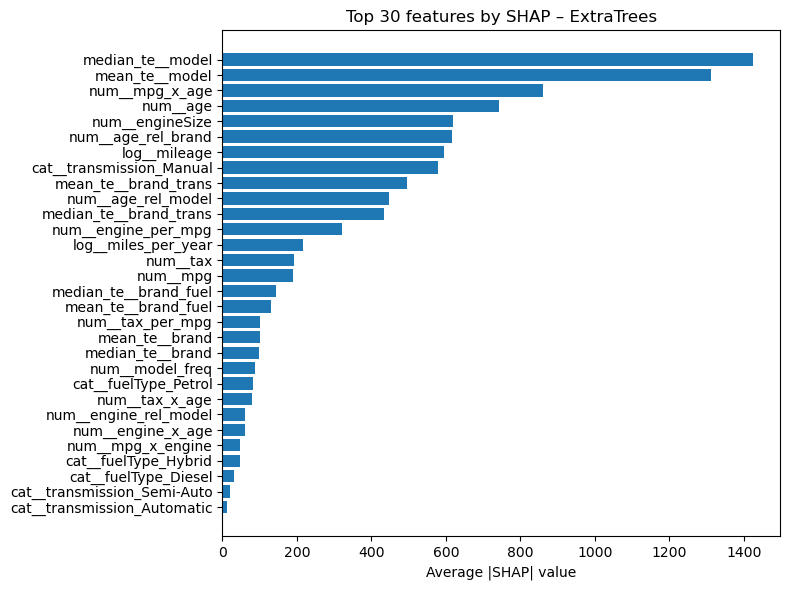

/var/folders/st/wy1z6qp53p5dffwzq_jkt4pw0000gn/T/ipykernel_58795/1661538182.py:23: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, X_df, max_display=max_display, show=False)


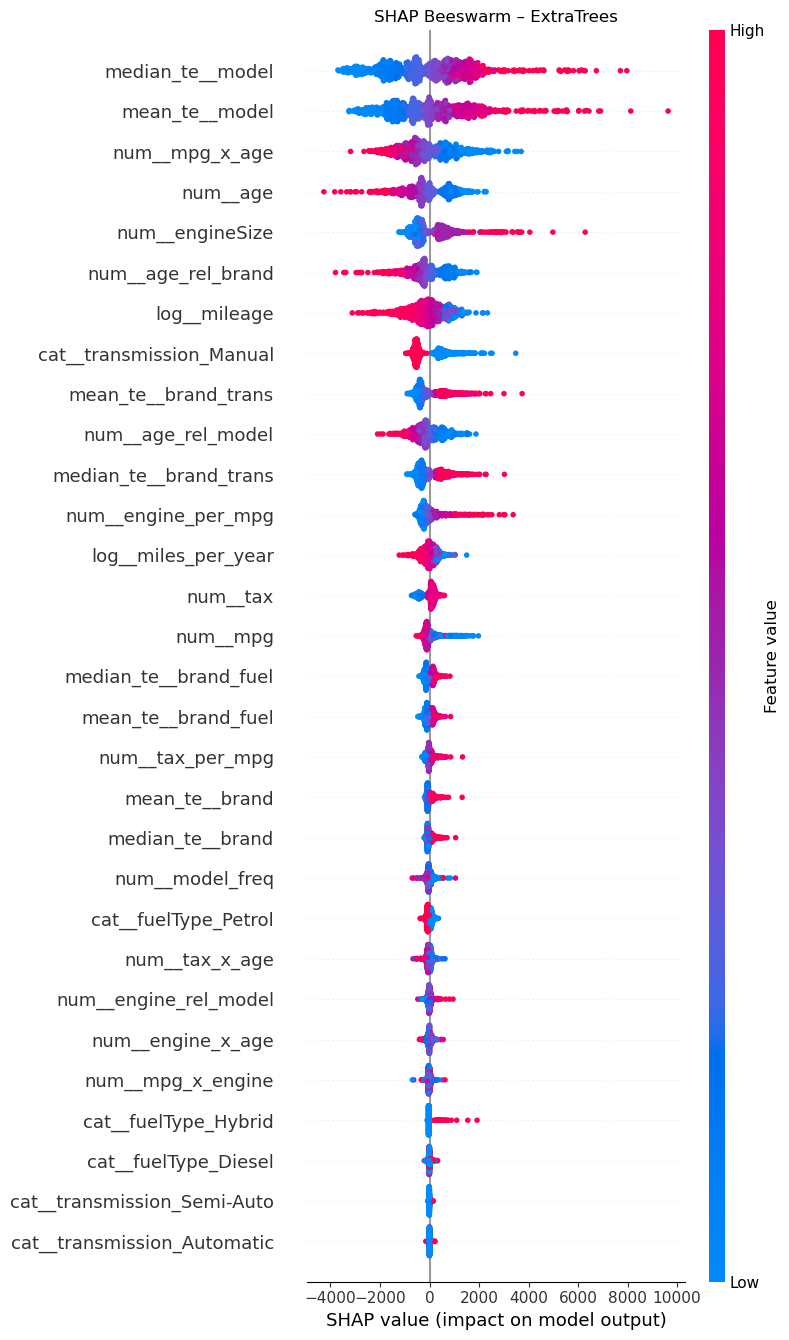

In [ ]:
# ExtraTrees baseline report + SHAP
et_pipe = et_tuned_pipe
df_cars_train = pd.read_csv("train.csv").rename(columns={"Brand": "brand",
                                                        "paintQuality%": "paintQuality"})
X_train = df_cars_train.drop(columns='price')

# Feature matrix + names after preprocess (clean+impute+fe+ct+fs)
X_proc_et, feat_names_et = get_pipeline_feature_matrix(et_pipe, X_train, preprocessor_pipe)
n_features_total_et = X_proc_et.shape[1]

print("ExtraTrees (tuned pipe) - feature space info:")
print(f"Total features used: {n_features_total_et}")

shap_importance_et, feat_names_et, shap_vals_et, X_sample_et = compute_shap_importance(
    et_pipe,
    X_train,
    sample_size=1000,
    seed=rs,
    model_name="ExtraTrees",
)

plot_top_shap_bar(shap_importance_et, model_name="ExtraTrees", top_k=n_features_total_et)
plot_shap_beeswarm(shap_vals_et, X_sample_et, feat_names_et, model_name="ExtraTrees", max_display=n_features_total_et)